# 1 Getting started

## Introducing the GeLaTo library

For this chapter, we will need the [GeLaTo](https://github.com/pyccel/GeLaTo) library. 

Let us consider the following weak formulation

$$\int_{\Omega} N_i N_j + \nabla N_i \cdot \nabla N_j ~d\Omega$$

In the case where $\Omega$ is the unit cube, we should expect the GLT symbol

$$
\mathfrak{m}_p(\theta_1) \mathfrak{m}_p(\theta_2) \mathfrak{m}_p(\theta_3) + \mathfrak{m}_p(\theta_1) \mathfrak{m}_p(\theta_2) \mathfrak{s}_p(\theta_3) + \mathfrak{m}_p(\theta_1) \mathfrak{s}_p(\theta_2) \mathfrak{m}_p(\theta_3) + \mathfrak{s}_p(\theta_1) \mathfrak{m}_p(\theta_2) \mathfrak{m}_p(\theta_3)
$$

In [1]:
# ... some imports
from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import IndexedBase

from gelato.glt import glt_symbol
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div)

In [2]:
x,y,z = symbols('x y z')

u = Symbol('u')
v = Symbol('v')

a = Lambda((x,y,z,v,u), Dot(Grad(u), Grad(v)))
print ('> input       := {0}'.format(a))

# ... create a glt symbol from a string without evaluation
#     a discretization is defined as a dictionary
discretization = {"n_elements": [16, 16, 16], "degrees": [3, 3, 3]}

expr = glt_symbol(a, discretization=discretization, evaluate=False)
print ('> glt symbol  := {0}'.format(expr))

> input       := Lambda((x, y, z, v, u), Dot(Grad(u), Grad(v)))
> glt symbol  := m1*m2*s3 + m1*m3*s2 + m2*m3*s1


We get a *sympy* expression, that we can manipulate like any other *sympy*
expression. Let's print it

In [3]:
print (expr)

m1*m2*s3 + m1*m3*s2 + m2*m3*s1


Good, but that's not readable for a human. You can now convert this expression to latex using

In [4]:
from IPython.display import Math
from sympy import latex

In [5]:
Math(latex(expr))

<IPython.core.display.Math object>

For pretty printing, you may need the **glt_latex** function

In [6]:
from gelato.printing.latex import glt_latex;
Math(glt_latex(expr))

<IPython.core.display.Math object>

Let's now **evaluate** our symbol (in the symbolic sens) in order to do some diagnostics

In [7]:
expr = glt_symbol(a, discretization=discretization, evaluate=True)

We recall that the eigenvalues of the matrix associated to our weak formulation can be *approximated* by a *uniform sampling* of the symbol

In [8]:
from gelato.glt import glt_approximate_eigenvalues
eig = glt_approximate_eigenvalues(expr, discretization=discretization)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

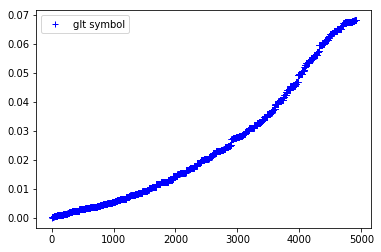

In [10]:
t = eig
t.sort()
plt.plot(t, "+b", label="glt symbol")
plt.legend(loc=2);

We will see later, another way of plotting these eigenvalues.
Another interesting feature of our symbol, is **numerical evaluation**. For this, you need to call the **glt_lambdify** function

In [11]:
from gelato.glt import glt_lambdify

f = glt_lambdify(expr)

Now $f$ is a function that you can evaluate numerically.

In [12]:
from numpy import pi
f(0.1,0.1,0.1,pi, pi, pi)

0.00029125724364162235

## Using SPL and GeLaTo

In this section, we show how to use both [GeLaTo](https://github.com/pyccel/GeLaTo) and [spl](https://github.com/pyccel/spl) in order to assemble a weak-formulation and study its spectral properties.

We start by the Laplace operator in **1D**. As in the previous section, we define its weak formulation using the **lambda** expression

In [13]:
# ... define the weak formulation
x = Symbol('x')

u = Symbol('u')
v = Symbol('v')

expr = Lambda((x,v,u), Dot(Grad(u), Grad(v)) + u*v)
# ...


In [14]:
# needed imports
from numpy import linspace
from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel

In [15]:
# ...  create a finite element space
p  = 3
ne = 64

print('> Grid   :: {ne}'.format(ne=ne))
print('> Degree :: {p}'.format(p=p))

grid = linspace(0., 1., ne+1)

V = SplineSpace(p, grid=grid)
# ...


> Grid   :: 64
> Degree :: 3


*GeLaTo* has a nice function **compile_kernel**, that constructs the FEM assembly kernel, given a weak formulation. You can call it this way:

In [16]:
kernel_py = compile_kernel('kernel_1', expr, V)

You can now assemble the corresponding matrix, using:

In [17]:
M_py  = assemble_matrix(V, kernel_py).tocsr()

The **compile_kernel** function has a **backend** argument which is used to decide the target language (*Python/Fortran*) for the kernel. The available choices are *'python'* or *'fortran'*. For *Fortran*, you can call it this way:

In [18]:
kernel_f90 = compile_kernel('kernel_1', expr, V, backend='fortran')
M_f90 = assemble_matrix(V, kernel_f90).tocsr()

Now, we convert the sparse matrix to a dense one, in order to use lapack eigenvalue solver.

In [19]:
M = M_f90.todense()

In [20]:
# import eigenvalue solver
from scipy.linalg import eig

w, v = eig(M)
wr = w.real
wr.sort()


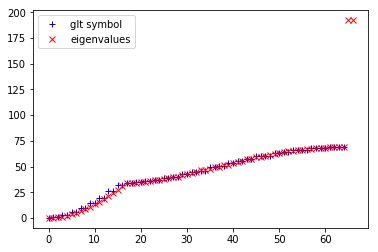

In [21]:
from gelato.glt import glt_approximate_eigenvalues

symbol = glt_symbol(expr, space=V, evaluate=True)

eig = glt_approximate_eigenvalues(symbol, space=V)
t = eig
t.sort()

plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()